#Mount Google Drive and Install Dependencies

In [10]:
from google.colab import drive
drive.mount('/content/drive')

!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


#Setuo Dectron2 and Import Libraries

In [11]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


#Convert JSON files and Merge Data

In [23]:
def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "/content/drive/MyDrive/Data/merged_training_annotations.json" if training else "/content/drive/MyDrive/Data/merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)


#Register Datates and Visualize

In [26]:
# 파일 경로 설정
training_json = "/content/drive/MyDrive/Data/merged_training_annotations.json"
validation_json = "/content/drive/MyDrive/Data/merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data/"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


AssertionError: Dataset 'vehicle_train' is already registered!

#Train the model

In [27]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/19 17:17:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/19 17:17:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/19 17:18:00 d2.utils.events]:  eta: 0:08:42  iter: 19  total_loss: 1.667  loss_cls: 1.24  loss_box_reg: 0.4023  loss_rpn_cls: 0.02042  loss_rpn_loc: 0.001861    time: 0.5812  last_time: 0.5173  data_time: 0.0911  last_data_time: 0.0081   lr: 4.9953e-06  max_mem: 2806M
[06/19 17:18:12 d2.utils.events]:  eta: 0:08:47  iter: 39  total_loss: 1.604  loss_cls: 1.115  loss_box_reg: 0.4414  loss_rpn_cls: 0.01895  loss_rpn_loc: 0.00193    time: 0.5916  last_time: 0.5027  data_time: 0.0786  last_data_time: 0.0194   lr: 9.9902e-06  max_mem: 2806M
[06/19 17:18:26 d2.utils.events]:  eta: 0:08:52  iter: 59  total_loss: 1.385  loss_cls: 0.9394  loss_box_reg: 0.4101  loss_rpn_cls: 0.01298  loss_rpn_loc: 0.001828    time: 0.6221  last_time: 0.5678  data_time: 0.1536  last_data_time: 0.0097   lr: 1.4985e-05  max_mem: 2806M
[06/19 17:18:39 d2.utils.events]:  eta: 0:08:56  iter: 79  total_loss: 1.122  loss_cls: 0.7063  loss_box_reg: 0.3696  loss_rpn_cls: 0.02191  loss_rpn_loc: 0.00154    time: 0.6368 

#Evaluate Model Performance

In [30]:
# 이미지에 대해 추론 수행
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(folder_path, predictor, metadata):
    if not os.path.isdir(folder_path):
        print(f"Error: Directory {folder_path} does not exist.")
        return

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if not os.path.isfile(file_path):
            print(f"Warning: {file_path} is not a valid file.")
            continue

        img = cv2.imread(file_path)
        if img is None:
            print(f"Error: Failed to load image {file_path}.")
            continue

        outputs = predictor(img)

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="/content/drive/MyDrive/Data/output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)


[06/19 17:33:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[06/19 17:33:51 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/19 17:33:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/19 17:33:51 d2.data.datasets.coco]: Loaded 60 images in COCO format from merged_validation_annotations.json
[06/19 17:33:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/19 17:33:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/19 17:33:51 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[06/19 17:33:51 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/19 17:33:51 d2.evaluation.evaluator]: Start in

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/19 17:33:55 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.0092 s/iter. Inference: 0.1816 s/iter. Eval: 0.0016 s/iter. Total: 0.1924 s/iter. ETA=0:00:09
[06/19 17:34:00 d2.evaluation.evaluator]: Inference done 29/60. Dataloading: 0.0600 s/iter. Inference: 0.1937 s/iter. Eval: 0.0020 s/iter. Total: 0.2569 s/iter. ETA=0:00:07
[06/19 17:34:05 d2.evaluation.evaluator]: Inference done 46/60. Dataloading: 0.0906 s/iter. Inference: 0.1821 s/iter. Eval: 0.0013 s/iter. Total: 0.2756 s/iter. ETA=0:00:03
[06/19 17:34:09 d2.evaluation.evaluator]: Total inference time: 0:00:14.802048 (0.269128 s / iter per device, on 1 devices)
[06/19 17:34:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:09 (0.169413 s / iter per device, on 1 devices)
[06/19 17:34:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:34:09 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/Data/output/coco_instances_results.json
[06/19 17:34

# easy ocr


#result image saving_change JSON to JPG

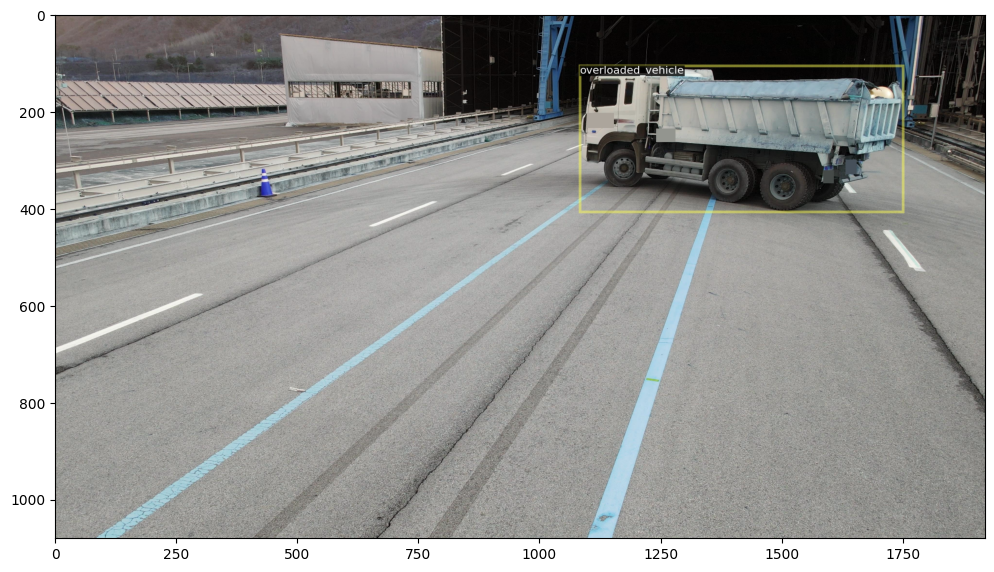

In [35]:
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# 결과 이미지 폴더 경로 설정
result_overload = "/content/drive/MyDrive/Data/output/coco_instances_results.json"  # 폴더 경로 지정

# Assume d is your dataset dictionary containing relevant information
# Load the image using OpenCV
img = cv2.imread(d["file_name"])

# Create a Visualizer instance and draw on the image
visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)

# Display the image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image()[:, :, ::-1])  # Show the image, converting BGR to RGB

# Save the plotted image as JPG
plt.savefig('/content/drive/MyDrive/Data/output/result.jpg')

# Show the plot
plt.show()


#import easy ocr

In [2]:
#you need to install pytorch in anaconda environment
import os
import locale
import subprocess

# Check if locale is set correctly locale.setlocale(locale.LC_ALL, 'UTF-8')

locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers==4.28.1

# Install EasyOCR
!pip install easyocr

  Using cached easyocr-1.7.1-py3-none-any.whl (2.9 MB)
  Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)
  Using cached pyclipper-1.3.0.post5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (908 kB)
  Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl 

#Text extraction

In [ ]:
reader.readtext('/content/drive/MyDrive/Data/output/result.jpg', detail=0)